# 앙상블과 주가수익률 예측
앙상블 전략과 Sentiment Analysis 활용을 투자 전략에 활용하기

- 학습내용
    - 모멘텀 요인 / 한국은행 API 소개
    - 주가 자료 다운로드 / 수익률, 수준, 모멘텀 데이터 준비
    - 기초통계 (상관곤계 확인 > feature selection)
    - 선형회귀(feature selection) / 선형회귀 모형
    - 앙상블 모형과 성과 비교
- 학습목표
    - 분석에 필요한 자료를 다운로드할 수 있다
    - 앙상블 모형과 선형회귀모형을 비교하고 분석할 수 있다
    - 실제 주가수익률 예측에 적용할 수 있다

## 모멘텀 요인 (Momentum Factor)
- 물리학
    - 어떤 물체가 주어진 축을 중심으로 일어나는 회전운동을 변화시키기 어려운 정도를 나타내는 물리량
- Finance
    - 고수익을 기록한 주식들은 지속적으로 고수익을 유지하는 경향을 보인다는 개념
    
### 모멘텀 요인의 발전
- Fama-Farnach 3요인 모형 : 주식시장의 이상현상(anomalies) 설명
- Jegadeesh and Titman : 모멘텀 관련 논문 발표
    - 모멘텀 요인이 Stock Return을 설명하는 Pricing Factor로 자리매김
- Carhart : 4요인 모형에 포함
    - FF3 Factor + momentum factor
    
### 모멘텀 요인의 구분
- 절대 모멘텀
    - Absolute Momentum
    - 시계열모멘텀 (Time-series momentum)
    - 추세추종 (Trend Following)
- 상대 모멘텀
    - 기준재(numeraire) 주식을 선정하여, 상대가격의 수익률로 모멘텀을 추정
    
> 실제 투자전략 운용에서는 두 가지 개념의 구분은 크게 중요하지 않음

### 모멘텀 요인의 투자전략 적용
- 특정 기간을 비교해 기간 중 수익률에 따라 서열화
- 상위(고수익) 주식 매수
- 하위(저수익) 주식 매도(공매도)
    - Long, short 전략을 동시에 취해 위험 최소화, 수익 극대화 전략
    
## 한국은행 Open API
- 환율, 이자율 및 거시경제 관련 데이터 다운로드 ([Link](http://ecos.bok.or.kr/jsp/openapi/OpenApiController.jsp?t=main))
    - 회원가입 절차 진행 후 OPEN API 인증키 신청, 생성
    - [API 사용 참고 - 블로그 포스팅](https://bjecondata.blogspot.com/2019/08/blog-post_7.html)
    - [Ecos Query Test page - 통계 조회 조건 설정](http://ecos.bok.or.kr/jsp/openapi/OpenApiController.jsp?t=guideServiceDtl&apiCode=OA-1040&menuGroup=MENU000004)
    - [Ecos 개발가이드 - 통계코드검색](http://ecos.bok.or.kr/jsp/openapi/OpenApiController.jsp?t=guideStatCd&menuGroup=MENU000004&menuCode=MENU000024)

In [144]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:
api_key = 'T0OXEM1G4MBFJRZ1OM6M'
data_type = 'xml'
period = 'MM'
start_date = '20100101'
finish_date = '20201031'
code = [('060Y001', '010502000'), ('060Y001', '010152000'), ('036Y001', '0000001')] # 첫번째 CD유통수익률, 두번째 KORIBOR 금리(12월물), 세번째 환율

In [98]:
exchange_rate_url = f'http://ecos.bok.or.kr/api/StatisticSearch/{api_key}/{data_type}/kr/1/100000/{code[2][0]}/{period}/{start_date}/{finish_date}/{code[2][1]}//'
cd_return_rate_url = f'http://ecos.bok.or.kr/api/StatisticSearch/{api_key}/{data_type}/kr/1/100000/{code[0][0]}/{period}/{start_date}/{finish_date}/{code[0][1]}//'
koribor_return_rate_url = f'http://ecos.bok.or.kr/api/StatisticSearch/{api_key}/{data_type}/kr/1/100000/{code[1][0]}/{period}/{start_date}/{finish_date}/{code[1][1]}//'

In [99]:
def EcosGetData(api_key, dtype, start_date, finish_date, tcode, icode, period, requestStart=1, requestFinish=100000):
    
    url = f'http://ecos.bok.or.kr/api/StatisticSearch/{api_key}/{data_type}/kr/{requestStart}/{requestFinish}/{tcode}/{period}/{start_date}/{finish_date}/{icode}/'
    #url = f'http://ecos.bok.or.kr/api/StatisticItemList/{api_key}/{data_type}/kr/{requestStart}/{requestFinish}/{tcode}/{period}/{start_date}/{finish_date}/{icode}/'
    print(url)
    
    raw = requests.get(url)
    xml = BeautifulSoup(raw.text, 'xml')
    
    raw_data = xml.find_all("row")
    
    #print(raw_data)
    
    date_list = []
    value_list = []
    
    for item in raw_data:
        #print(item)
        name = item.find("ITEM_NAME1").text
        value = item.find("DATA_VALUE").text.encode('utf-8')
        date_str = item.find('TIME').text
        
        #print(value, date_str)
        
        try:
            value = float(value)
        except:
            value = np.nan
        
        strp = ''
        if period == 'MM':
            strp = datetime.strptime(date_str, '%Y%m')
        elif period == 'DD':
            strp = datetime.strptime(date_str, '%Y%m%d')
        
        date_list.append(strp)
        value_list.append(value)
        
    df = pd.DataFrame(index = date_list)
    #df['%s' % (icode)] = value_list
    df[name] = value_list
    
    return df

In [100]:
df_cd_return_r = EcosGetData(api_key, data_type, start_date, finish_date, code[0][0], code[0][1], 'DD')
df_cd_return_r.head()

http://ecos.bok.or.kr/api/StatisticSearch/T0OXEM1G4MBFJRZ1OM6M/xml/kr/1/100000/060Y001/DD/20100101/20201031/010502000/


,CD(91일)
2010-01-04,2.88
2010-01-05,2.88
2010-01-06,2.88
2010-01-07,2.88
2010-01-08,2.88


In [101]:
df_koribor_return_r = EcosGetData(api_key, data_type, start_date, finish_date, code[1][0], code[1][1], 'DD')
df_koribor_return_r.head()

http://ecos.bok.or.kr/api/StatisticSearch/T0OXEM1G4MBFJRZ1OM6M/xml/kr/1/100000/060Y001/DD/20100101/20201031/010152000/


,KORIBOR(12개월)
2010-01-04,4.11
2010-01-05,4.12
2010-01-06,4.12
2010-01-07,4.11
2010-01-08,4.10


In [102]:
df_exchange_r = EcosGetData(api_key, data_type, start_date, finish_date, code[2][0], code[2][1], 'DD')
df_exchange_r.head()

http://ecos.bok.or.kr/api/StatisticSearch/T0OXEM1G4MBFJRZ1OM6M/xml/kr/1/100000/036Y001/DD/20100101/20201031/0000001/


,원/미국달러(매매기준율)
2010-01-04,1167.6
2010-01-05,1156.2
2010-01-06,1144.3
2010-01-07,1138.2
2010-01-08,1133.2


## 주가 데이터 다운로드

In [103]:
ksp = pdr.DataReader('^KS11', 'yahoo', start_date, finish_date) # 코스피
ss = pdr.DataReader('005930.KS', 'yahoo', start_date, finish_date) #삼전
hm = pdr.DataReader('005380.KS', 'yahoo', start_date, finish_date) #현차
snp = pdr.DataReader('^GSPC', 'yahoo', start_date, finish_date) #S&P 500
nki = pdr.DataReader('^N225', 'yahoo', start_date, finish_date) #닛케이225
uxt = pdr.DataReader('^N100', 'yahoo', start_date, finish_date) #유로넥스트100
vix = pdr.DataReader('^VIX', 'yahoo', start_date, finish_date) #VIX지수

In [104]:
ksp.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1696.140015,1681.709961,1681.709961,1696.140015,296500.0,1696.140015
2010-01-05,1702.390015,1686.449951,1701.619995,1690.619995,408900.0,1690.619995
2010-01-06,1706.890015,1696.099976,1697.880005,1705.319946,426000.0,1705.319946
2010-01-07,1707.900024,1683.449951,1702.920044,1683.449951,462400.0,1683.449951
2010-01-08,1695.260010,1668.839966,1694.060059,1695.260010,380000.0,1695.260010


### 수정 종가 따로 모으기

In [105]:
stk = pd.DataFrame({
    'ss' : ss['Close'],
    'hm' : hm['Adj Close'],
    'snp' : snp['Adj Close'],
    'ksp' : ksp['Adj Close'],
    'nki' : nki['Adj Close'],
    'uxt' : uxt['Adj Close'],
    'vix' : vix['Adj Close'],
    'exr' : df_exchange_r['원/미국달러(매매기준율)'],
    'koribor' : df_koribor_return_r['KORIBOR(12개월)'],
    'cd' : df_cd_return_r['CD(91일)']
}).dropna()

In [106]:
stk

,ss,hm,snp,ksp,nki,uxt,vix,exr,koribor,cd
2010-01-04,16180.0,96055.460938,1132.989990,1696.140015,10654.790039,696.989990,20.040001,1167.6,4.11,2.88
2010-01-05,16440.0,88790.750000,1136.520020,1690.619995,10681.830078,697.570007,19.350000,1156.2,4.12,2.88
2010-01-06,16820.0,89597.960938,1137.140015,1705.319946,10731.450195,698.270020,19.160000,1144.3,4.12,2.88
2010-01-07,16260.0,85562.007812,1141.689941,1683.449951,10681.660156,697.760010,19.059999,1138.2,4.11,2.88
2010-01-08,16420.0,85562.007812,1144.979980,1695.260010,10798.320312,701.380005,18.129999,1133.2,4.10,2.88
...,...,...,...,...,...,...,...,...,...,...
2020-10-26,60400.0,168784.968750,3400.969971,2343.909912,23494.339844,964.159973,32.459999,1134.6,0.89,0.63
2020-10-27,59800.0,169769.140625,3390.679932,2330.840088,23485.800781,954.159973,33.349998,1129.1,0.89,0.63
2020-10-28,59000.0,170753.296875,3271.030029,2345.260010,23418.509766,926.450012,40.279999,1127.6,0.89,0.63
2020-10-29,58100.0,167308.703125,3310.110107,2326.669922,23331.939453,927.950012,37.590000,1129.3,0.89,0.63


## 수익률과 수익률의 Lag 변수

In [107]:
# stk 데이터프레임의 모든 칼럼을 수익률 데이터로 전환
rtn = (np.log(stk) - np.log(stk.shift(1))) * 100  # 100 곱해서 퍼센트 단위로계산
rtn.columns = ['r_' + colname for colname in stk.columns]

rtn.head() # 첫번째 데이터는 missing > 수익률 계산하면서 LAG 시켰으므로

,r_ss,r_hm,r_snp,r_ksp,r_nki,r_uxt,r_vix,r_exr,r_koribor,r_cd
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,1.594148,-7.864326,0.311083,-0.325977,0.253461,0.083183,-3.503788,-0.981159,0.243013,0.0
2010-01-06,2.285126,0.905008,0.054537,0.865742,0.463453,0.100300,-0.986767,-1.034567,0.000000,0.0
2010-01-07,-3.386055,-4.609121,0.399322,-1.290751,-0.465043,-0.073066,-0.523289,-0.534503,-0.243013,0.0
2010-01-08,0.979200,0.000000,0.287758,0.699090,1.086233,0.517461,-5.002389,-0.440258,-0.243605,0.0


### 수익률의 Lag1 데이터 생성
- dataframe의 shift() 메소드 사용
- 마찬가지 방법으로 Lag2, Lag3, Lag4 데이터도 생성하여 향후에 Feature로 사용

### Lag 변수?
- 대부분의 파이낸스 시계열 데이터는 시계열 의존성이 매우 강함
- 시계열 의존성이 강한 상태에서 lag 변수는 그 다음 기의 변수를 설명하는 매우 높은 설명력을 지닌다
    - 따라서 수익률 데이터에 수익률의 모든 lag 데이터를 join시킨 rtns에 저장

In [108]:
def create_lag_df(df, num):
    df_lag = df.shift(int(num))
    df_lag.columns = [colname + '_lag' + str(num) for colname in df.columns]
    return df_lag

In [109]:
rtn_lag1 = create_lag_df(rtn, 1)
rtn_lag2 = create_lag_df(rtn, 2)
rtn_lag3 = create_lag_df(rtn, 3)
rtn_lag4 = create_lag_df(rtn, 4)

In [110]:
rtn_lag1.head()

,r_ss_lag1,r_hm_lag1,r_snp_lag1,r_ksp_lag1,r_nki_lag1,r_uxt_lag1,r_vix_lag1,r_exr_lag1,r_koribor_lag1,r_cd_lag1
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,1.594148,-7.864326,0.311083,-0.325977,0.253461,0.083183,-3.503788,-0.981159,0.243013,0.0
2010-01-07,2.285126,0.905008,0.054537,0.865742,0.463453,0.100300,-0.986767,-1.034567,0.000000,0.0
2010-01-08,-3.386055,-4.609121,0.399322,-1.290751,-0.465043,-0.073066,-0.523289,-0.534503,-0.243013,0.0


In [111]:
rtn_lag4.head()

,r_ss_lag4,r_hm_lag4,r_snp_lag4,r_ksp_lag4,r_nki_lag4,r_uxt_lag4,r_vix_lag4,r_exr_lag4,r_koribor_lag4,r_cd_lag4
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Lag 취합

In [112]:
# rtns 모으기
#rtns = rtn.join(rtn_lag1).join(rtn_lag2).join(rtn_lag3).join(rtn_lag4).dropna()

from functools import reduce
lags = [rtn, rtn_lag1, rtn_lag2, rtn_lag3, rtn_lag4]
rtns = reduce(lambda left,right: pd.concat([left,right], axis=1), lags).dropna()

In [113]:
rtns

,r_ss,r_hm,r_snp,r_ksp,r_nki,r_uxt,r_vix,r_exr,r_koribor,r_cd,...,r_ss_lag4,r_hm_lag4,r_snp_lag4,r_ksp_lag4,r_nki_lag4,r_uxt_lag4,r_vix_lag4,r_exr_lag4,r_koribor_lag4,r_cd_lag4
2010-01-12,-1.472419,-2.871015,-0.768021,0.199181,0.745657,-1.129859,0.659710,-1.189539,-1.227009,0.0,...,1.594148,-7.864326,0.311083,-0.325977,0.253461,0.083183,-3.503788,-0.981159,0.243013,0.0
2010-01-13,-1.494424,-0.975616,0.829146,-1.616034,-1.333491,0.135453,-2.216155,0.392157,-0.992564,0.0,...,2.285126,0.905008,0.054537,0.865742,0.463453,0.100300,-0.986767,-1.034567,0.000000,0.0
2010-01-14,3.695002,1.459878,0.242349,0.855484,1.595485,0.270357,-1.240158,0.195503,-0.249688,0.0,...,-3.386055,-4.609121,0.399322,-1.290751,-0.465043,-0.073066,-0.523289,-0.534503,-0.243013,0.0
2010-01-15,1.797532,4.255982,-1.088213,0.946410,0.679954,-1.245662,1.575726,-0.382478,0.000000,0.0,...,0.979200,0.000000,0.287758,0.699090,1.086233,0.517461,-5.002389,-0.440258,-0.243605,0.0
2010-01-19,-2.282381,-3.294438,1.242215,0.493546,-1.997576,1.181014,-1.859732,0.426857,0.000000,0.0,...,-1.472419,-2.871015,-0.768021,0.199181,0.745657,-1.129859,0.659710,-1.189539,-1.227009,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,0.331675,2.658949,-1.876447,-0.718437,-0.094659,-1.626470,16.400603,0.044078,0.000000,0.0,...,1.488861,-0.298068,0.471620,0.496050,-0.440711,0.023246,0.580901,-0.297229,0.000000,0.0
2020-10-27,-0.998344,0.581399,-0.303021,-0.559168,-0.036352,-1.042588,2.704919,-0.485931,0.000000,0.0,...,0.000000,-1.201210,-0.219811,0.526518,0.306830,-1.523515,-2.413913,-0.219116,0.000000,0.0
2020-10-28,-1.346822,0.578029,-3.592554,0.616752,-0.286929,-2.947125,18.879731,-0.132937,0.000000,0.0,...,-1.322333,-1.829325,0.520535,-0.669082,-0.701248,-0.198250,-1.902802,-0.527845,0.000000,0.0
2020-10-29,-1.537178,-2.037918,1.187652,-0.795825,-0.370351,0.161777,-6.911698,0.150649,0.000000,0.0,...,0.166251,2.731585,0.343984,0.244283,0.180122,0.760045,-2.012290,0.035276,0.000000,0.0


## 수준 데이터
### 환율, 금리, VIX 변수
- 환율, 금리, VIX의 log difference를 사용할 경우 너무 많은 정보 손실이 발생
- **수준 변수**를 사용함

In [114]:
stk.columns

Index(['ss', 'hm', 'snp', 'ksp', 'nki', 'uxt', 'vix', 'exr', 'koribor', 'cd'], dtype='object')

In [115]:
fifx = stk[['exr', 'koribor', 'cd', 'vix']].dropna()
fifx

,exr,koribor,cd,vix
2010-01-04,1167.6,4.11,2.88,20.040001
2010-01-05,1156.2,4.12,2.88,19.350000
2010-01-06,1144.3,4.12,2.88,19.160000
2010-01-07,1138.2,4.11,2.88,19.059999
2010-01-08,1133.2,4.10,2.88,18.129999
...,...,...,...,...
2020-10-26,1134.6,0.89,0.63,32.459999
2020-10-27,1129.1,0.89,0.63,33.349998
2020-10-28,1127.6,0.89,0.63,40.279999
2020-10-29,1129.3,0.89,0.63,37.590000


In [116]:
fifx_lags = [create_lag_df(fifx, i) for i in range(1, 5)] ### fifx lag1 - lag4

In [117]:
fifxs = reduce(lambda left,right: pd.concat([left,right], axis=1), fifx_lags).dropna()

In [118]:
fifxs

,exr_lag1,koribor_lag1,cd_lag1,vix_lag1,exr_lag2,koribor_lag2,cd_lag2,vix_lag2,exr_lag3,koribor_lag3,cd_lag3,vix_lag3,exr_lag4,koribor_lag4,cd_lag4,vix_lag4
2010-01-08,1138.2,4.11,2.88,19.059999,1144.3,4.12,2.88,19.160000,1156.2,4.12,2.88,19.350000,1167.6,4.11,2.88,20.040001
2010-01-12,1133.2,4.10,2.88,18.129999,1138.2,4.11,2.88,19.059999,1144.3,4.12,2.88,19.160000,1156.2,4.12,2.88,19.350000
2010-01-13,1119.8,4.05,2.88,18.250000,1133.2,4.10,2.88,18.129999,1138.2,4.11,2.88,19.059999,1144.3,4.12,2.88,19.160000
2010-01-14,1124.2,4.01,2.88,17.850000,1119.8,4.05,2.88,18.250000,1133.2,4.10,2.88,18.129999,1138.2,4.11,2.88,19.059999
2010-01-15,1126.4,4.00,2.88,17.629999,1124.2,4.01,2.88,17.850000,1119.8,4.05,2.88,18.250000,1133.2,4.10,2.88,18.129999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,1134.1,0.89,0.63,27.549999,1133.7,0.89,0.63,28.110001,1139.7,0.89,0.63,28.650000,1142.2,0.89,0.63,29.350000
2020-10-27,1134.6,0.89,0.63,32.459999,1134.1,0.89,0.63,27.549999,1133.7,0.89,0.63,28.110001,1139.7,0.89,0.63,28.650000
2020-10-28,1129.1,0.89,0.63,33.349998,1134.6,0.89,0.63,32.459999,1134.1,0.89,0.63,27.549999,1133.7,0.89,0.63,28.110001
2020-10-29,1127.6,0.89,0.63,40.279999,1129.1,0.89,0.63,33.349998,1134.6,0.89,0.63,32.459999,1134.1,0.89,0.63,27.549999


## 모멘텀 변수
### 모멘텀이 Stock Return을 예측하는 데 설명력이 있는가 확인
모멘텀 계산 시 주의할 점
- **현재 시점이 포함되면 곤란하다**
- 현재 시점을 예측해야 하는 입장에서, '현재 시점'이라는 것은 아직 변수인 상황
    - 따라서 모멘텀 변수는 예측할 수 없다
    - 모멘텀 변수를 계산할 때에는 어제 시점부터 더 먼 과거 어느시점 간의 수익률을 계산해야 함

In [119]:
stklag = stk.shift(1)
stklag

,ss,hm,snp,ksp,nki,uxt,vix,exr,koribor,cd
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,16180.0,96055.460938,1132.989990,1696.140015,10654.790039,696.989990,20.040001,1167.6,4.11,2.88
2010-01-06,16440.0,88790.750000,1136.520020,1690.619995,10681.830078,697.570007,19.350000,1156.2,4.12,2.88
2010-01-07,16820.0,89597.960938,1137.140015,1705.319946,10731.450195,698.270020,19.160000,1144.3,4.12,2.88
2010-01-08,16260.0,85562.007812,1141.689941,1683.449951,10681.660156,697.760010,19.059999,1138.2,4.11,2.88
...,...,...,...,...,...,...,...,...,...,...
2020-10-26,60200.0,164356.203125,3465.389893,2360.810059,23516.589844,979.969971,27.549999,1134.1,0.89,0.63
2020-10-27,60400.0,168784.968750,3400.969971,2343.909912,23494.339844,964.159973,32.459999,1134.6,0.89,0.63
2020-10-28,59800.0,169769.140625,3390.679932,2330.840088,23485.800781,954.159973,33.349998,1129.1,0.89,0.63
2020-10-29,59000.0,170753.296875,3271.030029,2345.260010,23418.509766,926.450012,40.279999,1127.6,0.89,0.63


### STK lag에 대하여 모멘텀 변수 계산
- 시점 기준 2일/3일/4일 단기간으로 잡고 계산
    - (예) 4d = 과거 4일간의 수익률 의미
- notation
     - week = 1w, 2w
     - month = 1m, 3m, 6m, 12m
- 기간 계산 (거래일 기준)
    - 1 week = 5 days
    - 2 week = 10 days
    - 1 month = 22~24 days
        - **for convenience, 1 month = 20 days / 3 months = 60 days**

In [120]:
def pct_change_for_lag(df, periodsNum):
    df_pct_change = df.pct_change(periods=periodsNum)*100
    df_pct_change.columns = [colname + f'_{periodsNum}d' for colname in df_pct_change.columns]
    return df_pct_change


### 2d, 3d, 4d, 1w, 2w, 1m, 3m, 6m, 12m
periods = [2, 3, 4, 5, 10, 20, 60, 120, 240]
stk_list = [pct_change_for_lag(stklag, pNum) for pNum in periods]
stk_m = reduce(lambda left,right: pd.concat([left,right], axis=1), stk_list).dropna()

stk_m.head()

,ss_2d,hm_2d,snp_2d,ksp_2d,nki_2d,uxt_2d,vix_2d,exr_2d,koribor_2d,cd_2d,...,ss_240d,hm_240d,snp_240d,ksp_240d,nki_240d,uxt_240d,vix_240d,exr_240d,koribor_240d,cd_240d
2011-01-24,-2.607823,-3.886015,0.111546,-2.163361,-2.676683,0.613962,6.701328,0.125358,1.149425,0.671141,...,20.024722,57.241776,13.271078,22.037090,-3.569010,2.982832,-7.834339,-4.230901,-14.355231,4.166667
2011-01-25,-1.120163,-3.350506,0.826391,-1.162978,-0.883362,1.370941,-1.889940,0.853933,1.142857,0.333333,...,18.126521,71.941105,13.578287,23.159546,-3.152266,3.244120,-8.785533,-2.957966,-14.077670,4.513889
2011-01-26,0.411946,2.156351,0.610128,0.809210,1.848265,0.050153,-4.764479,0.187802,0.852273,0.333333,...,15.933413,72.209555,13.546268,22.362371,-2.488296,2.845603,-8.194153,-2.097352,-13.834951,4.513889
2011-01-27,2.780639,5.333343,0.448548,1.359168,0.548955,0.309633,-5.722381,-0.392157,0.564972,0.000000,...,22.755228,87.945676,13.571116,25.365174,-2.619066,3.535597,-12.696748,-1.809875,-13.381995,4.513889
2011-01-28,1.948718,3.430049,0.647469,1.358149,0.136082,0.875871,-8.186473,-0.187450,0.563380,0.332226,...,21.071864,86.518166,13.498931,24.760214,-2.960277,3.286377,-10.921123,-1.323685,-12.926829,4.861111


## `rtns`, `fifxs`, `stk_m` 취합

In [121]:
A = stk_m.join(rtns).join(fifxs).dropna()
A

,ss_2d,hm_2d,snp_2d,ksp_2d,nki_2d,uxt_2d,vix_2d,exr_2d,koribor_2d,cd_2d,...,cd_lag2,vix_lag2,exr_lag3,koribor_lag3,cd_lag3,vix_lag3,exr_lag4,koribor_lag4,cd_lag4,vix_lag4
2011-01-24,-2.607823,-3.886015,0.111546,-2.163361,-2.676683,0.613962,6.701328,0.125358,1.149425,0.671141,...,3.00,17.990000,1116.8,3.48,2.98,17.309999,1114.7,3.46,2.98,15.870000
2011-01-25,-1.120163,-3.350506,0.826391,-1.162978,-0.883362,1.370941,-1.889940,0.853933,1.142857,0.333333,...,3.00,18.469999,1112.5,3.50,3.00,17.990000,1116.8,3.48,2.98,17.309999
2011-01-26,0.411946,2.156351,0.610128,0.809210,1.848265,0.050153,-4.764479,0.187802,0.852273,0.333333,...,3.01,17.650000,1118.2,3.52,3.00,18.469999,1112.5,3.50,3.00,17.990000
2011-01-27,2.780639,5.333343,0.448548,1.359168,0.548955,0.309633,-5.722381,-0.392157,0.564972,0.000000,...,3.01,17.590000,1122.0,3.54,3.01,17.650000,1118.2,3.52,3.00,18.469999
2011-01-28,1.948718,3.430049,0.647469,1.358149,0.136082,0.875871,-8.186473,-0.187450,0.563380,0.332226,...,3.01,16.639999,1120.3,3.55,3.01,17.590000,1122.0,3.54,3.01,17.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,-1.149425,0.906342,0.868267,-0.423899,-0.519771,0.563376,-3.839443,-0.491357,0.000000,0.000000,...,0.63,28.110001,1139.7,0.89,0.63,28.650000,1142.2,0.89,0.63,29.350000
2020-10-27,0.499168,5.538469,-1.520781,-0.473032,0.085499,-0.862682,15.474914,0.079386,0.000000,0.000000,...,0.63,27.549999,1133.7,0.89,0.63,28.110001,1139.7,0.89,0.63,28.650000
2020-10-28,-0.664452,3.293418,-2.155889,-1.269478,-0.130925,-2.633754,21.052629,-0.440878,0.000000,0.000000,...,0.63,32.459999,1134.1,0.89,0.63,27.549999,1133.7,0.89,0.63,28.110001
2020-10-29,-2.317881,1.166175,-3.820673,0.057600,-0.322759,-3.911173,24.091189,-0.616958,0.000000,0.000000,...,0.63,33.349998,1134.6,0.89,0.63,32.459999,1134.1,0.89,0.63,27.549999


## Target 설정 : `KOSPI` 수익률

In [122]:
y = A['r_ksp']
y

2011-01-24    0.589585
2011-01-25    0.216368
2011-01-26    1.133646
2011-01-27    0.215363
2011-01-28   -0.338153
                ...   
2020-10-26   -0.718437
2020-10-27   -0.559168
2020-10-28    0.616752
2020-10-29   -0.795825
2020-10-30   -2.591453
Name: r_ksp, Length: 2187, dtype: float64

## Feature 설정
- 고려한 모든 변수들을 리스트업 > 변수 X에 저장
    - Target과 Feature와의 상관관계를 파악하기 위해, X 데이터셋에 임시로 target을 포함시킴

In [123]:
A.columns

Index(['ss_2d', 'hm_2d', 'snp_2d', 'ksp_2d', 'nki_2d', 'uxt_2d', 'vix_2d',
       'exr_2d', 'koribor_2d', 'cd_2d',
       ...
       'cd_lag2', 'vix_lag2', 'exr_lag3', 'koribor_lag3', 'cd_lag3',
       'vix_lag3', 'exr_lag4', 'koribor_lag4', 'cd_lag4', 'vix_lag4'],
      dtype='object', length=156)

## 기초 통계 확인
### Feature Selection
- `A` 데이터셋 피쳐 가짓수가 너무 많아서 기초통계 확인 쉽지 않음
- Feature set 중 일부만 확인해 기초 통계를 확인

In [124]:
'vix' in A.columns

False

In [126]:
A

,ss_2d,hm_2d,snp_2d,ksp_2d,nki_2d,uxt_2d,vix_2d,exr_2d,koribor_2d,cd_2d,...,cd_lag2,vix_lag2,exr_lag3,koribor_lag3,cd_lag3,vix_lag3,exr_lag4,koribor_lag4,cd_lag4,vix_lag4
2011-01-24,-2.607823,-3.886015,0.111546,-2.163361,-2.676683,0.613962,6.701328,0.125358,1.149425,0.671141,...,3.00,17.990000,1116.8,3.48,2.98,17.309999,1114.7,3.46,2.98,15.870000
2011-01-25,-1.120163,-3.350506,0.826391,-1.162978,-0.883362,1.370941,-1.889940,0.853933,1.142857,0.333333,...,3.00,18.469999,1112.5,3.50,3.00,17.990000,1116.8,3.48,2.98,17.309999
2011-01-26,0.411946,2.156351,0.610128,0.809210,1.848265,0.050153,-4.764479,0.187802,0.852273,0.333333,...,3.01,17.650000,1118.2,3.52,3.00,18.469999,1112.5,3.50,3.00,17.990000
2011-01-27,2.780639,5.333343,0.448548,1.359168,0.548955,0.309633,-5.722381,-0.392157,0.564972,0.000000,...,3.01,17.590000,1122.0,3.54,3.01,17.650000,1118.2,3.52,3.00,18.469999
2011-01-28,1.948718,3.430049,0.647469,1.358149,0.136082,0.875871,-8.186473,-0.187450,0.563380,0.332226,...,3.01,16.639999,1120.3,3.55,3.01,17.590000,1122.0,3.54,3.01,17.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,-1.149425,0.906342,0.868267,-0.423899,-0.519771,0.563376,-3.839443,-0.491357,0.000000,0.000000,...,0.63,28.110001,1139.7,0.89,0.63,28.650000,1142.2,0.89,0.63,29.350000
2020-10-27,0.499168,5.538469,-1.520781,-0.473032,0.085499,-0.862682,15.474914,0.079386,0.000000,0.000000,...,0.63,27.549999,1133.7,0.89,0.63,28.110001,1139.7,0.89,0.63,28.650000
2020-10-28,-0.664452,3.293418,-2.155889,-1.269478,-0.130925,-2.633754,21.052629,-0.440878,0.000000,0.000000,...,0.63,32.459999,1134.1,0.89,0.63,27.549999,1133.7,0.89,0.63,28.110001
2020-10-29,-2.317881,1.166175,-3.820673,0.057600,-0.322759,-3.911173,24.091189,-0.616958,0.000000,0.000000,...,0.63,33.349998,1134.6,0.89,0.63,32.459999,1134.1,0.89,0.63,27.549999


In [152]:
A_c = A.copy()
A_c['vix'] = vix['Adj Close']
A_c = A_c.dropna()
X = A_c.copy()

In [129]:
X_select = A_c[['r_ksp',
             'r_snp', 'r_uxt', 'vix',
             'r_snp_lag1', 'r_uxt_lag1', 'vix_lag1',
             'r_snp_lag2', 'r_uxt_lag2', 'vix_lag2',
              'r_snp_lag3', 'r_uxt_lag3', 'vix_lag3',
              'r_snp_lag4', 'r_uxt_lag4', 'vix_lag4',
              
              'r_ksp_lag1', 'r_ss_lag1', 'r_hm_lag1',
              'r_ksp_lag2', 'r_ss_lag2', 'r_hm_lag2',
              'r_ksp_lag3', 'r_ss_lag3', 'r_hm_lag3',
              'r_ksp_lag4', 'r_ss_lag4', 'r_hm_lag4',
              
              'exr_lag1', 'koribor_lag1', 'cd_lag1',
              'exr_lag2', 'koribor_lag2', 'cd_lag2',
              'exr_lag3', 'koribor_lag3', 'cd_lag3',
              'exr_lag4', 'koribor_lag4', 'cd_lag4'
]]

## 데이터 기초통계 파악
- 평균
- 표준편차
- 왜도
- 첨도
- 상관관계 (시각화 등)

In [130]:
df = X_select.copy()
stats = df.describe()
stats.loc['var'] = stats.var().tolist()
stats.loc['skew'] = stats.skew().tolist()
stats.loc['kurt'] = stats.kurtosis().tolist()

stats

,r_ksp,r_snp,r_uxt,vix,r_snp_lag1,r_uxt_lag1,vix_lag1,r_snp_lag2,r_uxt_lag2,vix_lag2,...,cd_lag1,exr_lag2,koribor_lag2,cd_lag2,exr_lag3,koribor_lag3,cd_lag3,exr_lag4,koribor_lag4,cd_lag4
count,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,...,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000
mean,0.004162,0.042767,0.011888,17.431449,0.043435,0.012211,17.422510,0.042832,0.011949,17.413548,...,2.117961,1125.682487,2.223237,2.119044,1125.677549,2.224422,2.120119,1125.670965,2.225597,2.121193
std,1.088040,1.166272,1.238433,7.537861,1.165967,1.238605,7.525015,1.165715,1.238634,7.512647,...,0.812191,48.388869,0.823414,0.811785,48.389224,0.823358,0.811369,48.389738,0.823286,0.810950
min,-8.766972,-12.765220,-12.751740,9.140000,-12.765220,-12.751740,9.140000,-12.765220,-12.751740,9.140000,...,0.630000,1008.900000,0.770000,0.630000,1008.900000,0.770000,0.630000,1008.900000,0.770000,0.630000
25%,-0.463550,-0.351269,-0.539302,12.930000,-0.350176,-0.539302,12.930000,-0.350176,-0.539302,12.930000,...,1.530000,1088.900000,1.590000,1.530000,1088.900000,1.590000,1.530000,1088.900000,1.590000,1.530000
50%,0.043705,0.067597,0.071543,15.270000,0.068745,0.071543,15.270000,0.067597,0.069993,15.270000,...,1.800000,1125.600000,1.990000,1.800000,1125.600000,1.990000,1.800000,1125.600000,1.990000,1.800000
75%,0.568208,0.556062,0.632921,19.020000,0.556062,0.633429,19.005000,0.555055,0.633429,18.985000,...,2.690000,1159.250000,2.770000,2.690000,1159.250000,2.770000,2.690000,1159.250000,2.770000,2.690000
max,8.251268,8.968323,7.858973,82.690002,8.968323,7.858973,82.690002,8.968323,7.858973,82.690002,...,3.590000,1274.600000,3.880000,3.590000,1274.600000,3.880000,3.590000,1274.600000,3.880000,3.590000
var,597835.451251,598086.909717,598174.881287,585728.784548,598086.706382,598174.803192,585731.719581,598086.940822,598174.942275,585735.010137,...,596843.808651,332175.719639,596775.519169,596843.755903,332175.612383,596775.431206,596843.704766,332175.457039,596775.345174,596843.653758
skew,2.999924,2.999924,2.999924,2.999922,2.999924,2.999924,2.999922,2.999924,2.999924,2.999922,...,2.999924,2.999862,2.999924,2.999924,2.999862,2.999924,2.999924,2.999862,2.999924,2.999924


## Heatmap 시각화 통한 상관관계 파악?
변수가 많아서 하나하나 파악하는 데 한계 있음
- 일단 몇 가지...
    - lag된 koribor와 cd금리 간 상관관계는 거의 1에 가깝다
    - lag되지 않은 상관관계도 거의 1에 가까운 모습을 보여줌
        - **koribor와 cd금리는 거의 같은 정보이므로 cd금리만 사용**

<AxesSubplot:>

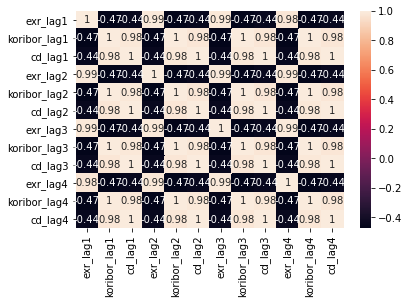

In [139]:
sns.heatmap(X_select[X_select.columns[-12:]].corr(), annot=True)

## Heatmap 통한 VIX와의 상관관계 파악
- `VIX`는 serial dependence가 매우 높으므로, VIX와 VIX lag 변수와도 상관관계 높음
- VIX의 경우 lag 변수는 사용하지 않는 것으로 결정

<AxesSubplot:>

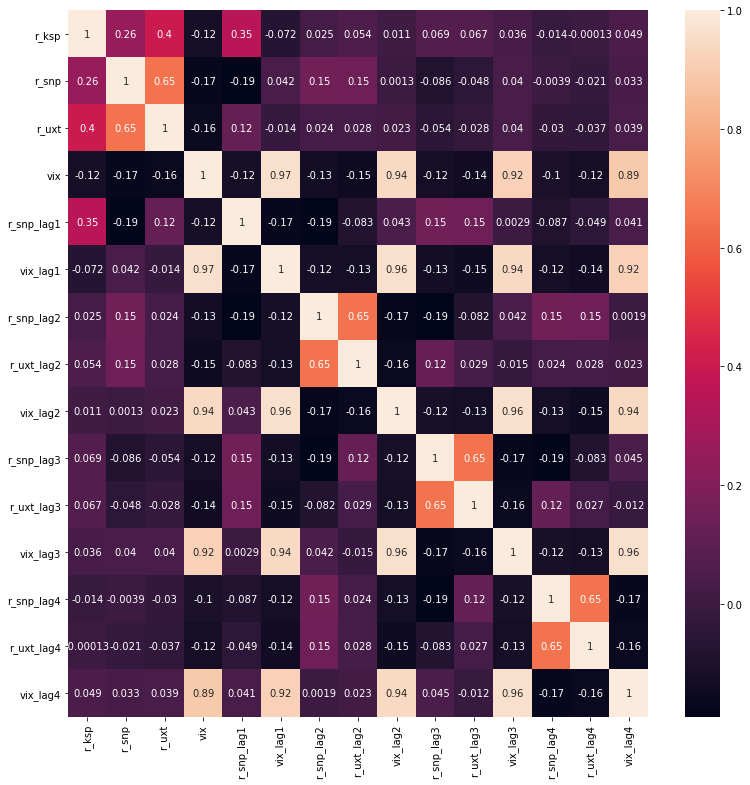

In [146]:
plt.figure(figsize=(13, 13))
colname_li = ['r_ksp', 'r_snp', 'r_uxt', 'vix', 'r_snp_lag1', 'vix_lag1',
             'r_snp_lag2', 'r_uxt_lag2', 'vix_lag2', 'r_snp_lag3', 'r_uxt_lag3', 'vix_lag3',
             'r_snp_lag4', 'r_uxt_lag4', 'vix_lag4']
sns.heatmap(X_select[colname_li].corr(), annot=True)

### Weekly Momentum 간의 상관관계
- weekly momentum의 경우, cd-koribor 금리 상관관계가 daily에 비해 많이 낮아진 상태
- koribor, cd 금리의 daily momentum 변수는 함께 사용해도 무방하다고 판단

<AxesSubplot:>

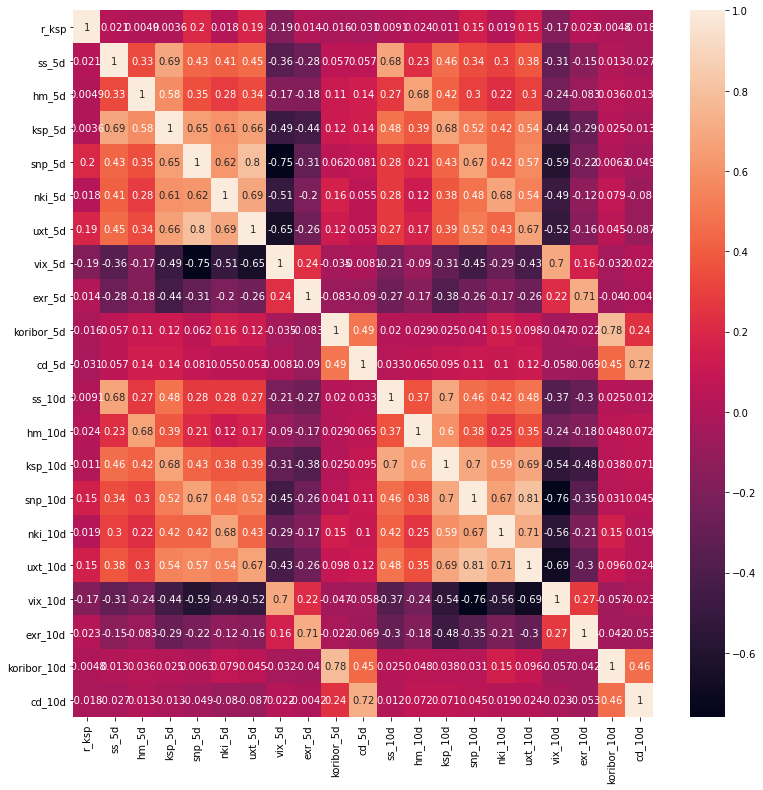

In [151]:
colname_momentum = ['r_ksp',
                   'ss_5d', 'hm_5d', 'ksp_5d', 'snp_5d', 'nki_5d', 'uxt_5d', 'vix_5d', 'exr_5d', 'koribor_5d', 'cd_5d',
                   'ss_10d', 'hm_10d', 'ksp_10d', 'snp_10d', 'nki_10d', 'uxt_10d', 'vix_10d', 'exr_10d', 'koribor_10d', 'cd_10d'
                   ]

plt.figure(figsize=(13, 13))
sns.heatmap(A[colname_momentum].corr(), annot=True)

## Weekly Momentum Features 상관관계
Heatmap / Pairplot의 경우,
- 여전히 변수가 많아서 눈으로 파악하는 데 한계가 있음
- 하지만 환율, cd 간 월별 모멘텀 간 상관관계가 높은 것은 뚜렷하게 관찰됨
- cd의 Monthly momentum 삭제

### Feature selection
기준에 따라 feature를 생략하거나 선택함
- "feature engineering"

### 선형회귀분석을 통한 Feature Selection
- t-값과 유의수준을 확인
- 추정치 유의 수준이 10% 이하인 경우 Feature 선택


In [154]:
import statsmodels.api as sm

X_const = sm.add_constant(X)
olsreg = sm.OLS(y, X_const)
result = olsreg.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  r_ksp   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.402e+26
Date:                Sun, 31 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:34:38   Log-Likelihood:                 61568.
No. Observations:                2187   AIC:                        -1.228e+05
Df Residuals:                    2029   BIC:                        -1.219e+05
Df Model:                         157                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.531e-14   3.14e-13     -0.081      0.936   -6.42e-13    5.91e-13
ss_2d          -3.886e-16   8.62e-14     -0.005      0.996   -1.69e-13    1.69e-13
hm_2d           5.718e-15   6.04e-14      0.095      0.925   -1.13e-13    1.24e-13
snp_2d         -3.775e-15   2.25e-13     -0.017      0.987   -4.44e-13    4.37e-13
ksp_2d          3.331e-16   2.42e-13      0.001      0.999   -4.74e-13    4.75e-13
nki_2d           2.22e-16   1.34e-13      0.002      0.999   -2.62e-13    2.62e-13
uxt_2d          8.882e-16   1.81e-13      0.005      0.996   -3.54e-13    3.55e-13
vix_2d         -1.249e-16    3.3e-15     -0.038      0.970    -6.6e-15    6.35e-15
exr_2d         -2.665e-14   1.13e-12     -0.024      0.981   -2.25e-12     2.2e-12
koribor_2d      8.882e-16   3.52e-13      0.003      0.998   -6.89e-13    6.91e-13
cd_2d           5.301e-15   9.01e-14      0.059      0.953   -1.71e-13    1.82e-13
ss_3d            7.91e-16   8.67e-14      0.009      0.993   -1.69e-13    1.71e-13
hm_3d          -1.665e-15   5.03e-14     -0.033      0.974      -1e-13    9.69e-14
snp_3d          4.552e-15    1.4e-13      0.033      0.974    -2.7e-13    2.79e-13
ksp_3d           6.55e-15   2.24e-13      0.029      0.977   -4.34e-13    4.47e-13
nki_3d         -3.553e-15   1.23e-13     -0.029      0.977   -2.45e-13    2.37e-13
uxt_3d         -3.109e-15   1.63e-13     -0.019      0.985   -3.22e-13    3.16e-13
vix_3d         -4.163e-17    3.3e-15     -0.013      0.990   -6.51e-15    6.43e-15
exr_3d         -1.688e-14   9.52e-13     -0.018      0.986   -1.88e-12    1.85e-12
koribor_3d      4.441e-16   3.31e-13      0.001      0.999   -6.48e-13    6.49e-13
cd_3d          -2.831e-15   9.56e-14     -0.030      0.976    -1.9e-13    1.85e-13
ss_4d           1.027e-15   6.27e-14      0.016      0.987   -1.22e-13    1.24e-13
hm_4d          -6.939e-16   3.36e-14     -0.021      0.984   -6.65e-14    6.51e-14
snp_4d          4.885e-15    1.3e-13      0.038      0.970    -2.5e-13     2.6e-13
ksp_4d          1.998e-15   1.43e-13      0.014      0.989   -2.78e-13    2.82e-13
nki_4d         -3.109e-15   8.35e-14     -0.037      0.970   -1.67e-13    1.61e-13
uxt_4d         -3.442e-15   1.11e-13     -0.031      0.975   -2.21e-13    2.14e-13
vix_4d          2.255e-16   2.35e-15      0.096      0.923   -4.38e-15    4.83e-15
exr_4d          2.665e-15    5.7e-13      0.005      0.996   -1.12e-12    1.12e-12
koribor_4d      -2.22e-15   1.65e-13     -0.013      0.989   -3.26e-13    3.22e-13
cd_4d          -4.996e-16   6.01e-14     -0.008      0.993   -1.18e-13    1.17e-13
ss_5d           1.301e-17    2.7e-15      0.005      0.996   -5.28e-15    5.31e-15
hm_5d          -5.291e-17   1.96e-15     -0.027      0.978   -3.89e-15    3.79e-15
snp_5d          5.274e-16   5.93e-15      0.089      0.929   -1.11e-14    1.22e-14
ksp_5d      

### 선형회귀분석 결과 > Feature 유의수준 확인
해외 주식시장 (r)
- S&P500 lag1-4, Euronext lag1-2, VIX lag1-3 선택

국내 주식시장 (r)
- KOSPI lag 1-4, 현대차 lag 1-4 선택

주별 모멘텀
- hm_1w, nki_1w, vix_1w, vix_2w, cd_2w

월별 모멘텀
- uxt_1m, vix_1m, ss_3m, uxt_3m, ss_6m, vix_12m, koribor_12m

In [156]:
X.columns.tolist()

['ss_2d',
 'hm_2d',
 'snp_2d',
 'ksp_2d',
 'nki_2d',
 'uxt_2d',
 'vix_2d',
 'exr_2d',
 'koribor_2d',
 'cd_2d',
 'ss_3d',
 'hm_3d',
 'snp_3d',
 'ksp_3d',
 'nki_3d',
 'uxt_3d',
 'vix_3d',
 'exr_3d',
 'koribor_3d',
 'cd_3d',
 'ss_4d',
 'hm_4d',
 'snp_4d',
 'ksp_4d',
 'nki_4d',
 'uxt_4d',
 'vix_4d',
 'exr_4d',
 'koribor_4d',
 'cd_4d',
 'ss_5d',
 'hm_5d',
 'snp_5d',
 'ksp_5d',
 'nki_5d',
 'uxt_5d',
 'vix_5d',
 'exr_5d',
 'koribor_5d',
 'cd_5d',
 'ss_10d',
 'hm_10d',
 'snp_10d',
 'ksp_10d',
 'nki_10d',
 'uxt_10d',
 'vix_10d',
 'exr_10d',
 'koribor_10d',
 'cd_10d',
 'ss_20d',
 'hm_20d',
 'snp_20d',
 'ksp_20d',
 'nki_20d',
 'uxt_20d',
 'vix_20d',
 'exr_20d',
 'koribor_20d',
 'cd_20d',
 'ss_60d',
 'hm_60d',
 'snp_60d',
 'ksp_60d',
 'nki_60d',
 'uxt_60d',
 'vix_60d',
 'exr_60d',
 'koribor_60d',
 'cd_60d',
 'ss_120d',
 'hm_120d',
 'snp_120d',
 'ksp_120d',
 'nki_120d',
 'uxt_120d',
 'vix_120d',
 'exr_120d',
 'koribor_120d',
 'cd_120d',
 'ss_240d',
 'hm_240d',
 'snp_240d',
 'ksp_240d',
 'nki_240d',

In [157]:
final_features = ['r_snp_lag1', 'r_snp_lag2', 'r_snp_lag3', 'r_snp_lag4',
                 'r_uxt_lag1', 'r_uxt_lag2', 'vix_lag1', 'vix_lag2', 'vix_lag3',
                 'r_ksp_lag1', 'r_ksp_lag2', 'r_ksp_lag3', 'r_ksp_lag4',
                 'r_hm_lag1', 'r_hm_lag2', 'r_hm_lag3', 'r_hm_lag4',
                 'hm_5d', 'nki_5d', 'vix_5d', 'vix_10d', 'cd_10d',
                 'uxt_20d', 'vix_20d', 'ss_60d', 'uxt_60d', 'ss_120d', 'vix_240d', 'koribor_240d']

In [162]:
X = X[final_features]

## Scikit-learn을 이용한 선형회귀분석


In [174]:
from sklearn.linear_model import LinearRegression
from datetime import datetime

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])
        
    def get_model(self):
        return LinearRegression(fit_intercept=False)
    
    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()
        
        for date in df[start_date:end_date].index:
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            model.fit(x, y.ravel())
            
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])
            
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred]
            
    def get_prices_since(self, df, date_since, lookback):
        index = df.index.get_loc(date_since)
        return df.iloc[index-lookback:index]

In [175]:
multi_linear_model = LinearRegressionModel()
multi_linear_model.learn(X, y, start_date='2015-01-01', end_date = '2020-10-31', lookback_period=420)

## 그래프로 나타내기

<AxesSubplot:title={'center':'Actual versus Predicted percentage returns'}>

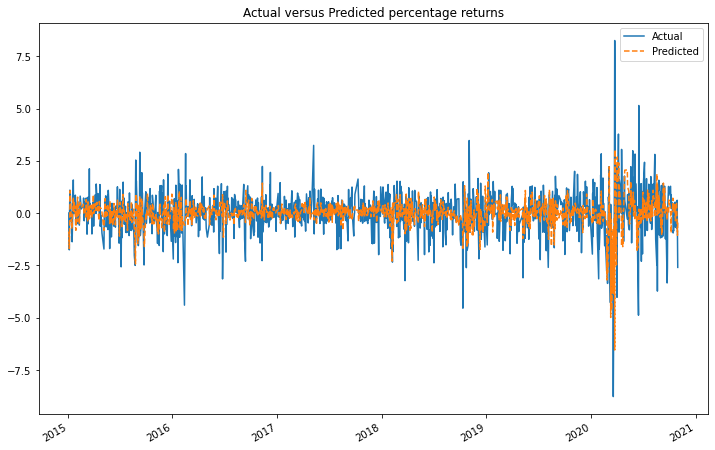

In [176]:
multi_linear_model.df_result.plot(
    title='Actual versus Predicted percentage returns',
    style=['-', '--'], figsize=(12, 8)
)

## 선형회귀분석 모델의 성과지표
시각적이 아닌 수치적으로 성능 확인
- 결정계수 (R squared)
    - `1 - (Sum of Squared Residuals / Total Variance)`
- 설명분산점수
    - `1 - ((Sum of Squared Residuals - Mean Error) / Total Variance)`
    
    > 평균의 분산이 없을 경우, 위의 두 지표는 동일함
    
**모형 비교 시, Mean Squared Error와 R-Squared Score 두가지를 중심으로 확인**
- R-squared : 움직임의 1% 미만을 설명하고 있다 (매우 작은 수준)

In [177]:
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

def printRegScore(y_true, y_pred):
    print('explained_variance_score: {}'.format(explained_variance_score(y_true, y_pred)))
    print('mean_squared_errors: {}'.format(mean_squared_error(y_true, y_pred)))
    print('r2_score: {}'.format(r2_score(y_true, y_pred)))

In [178]:
res = multi_linear_model.df_result
printRegScore(res['Actual'], res['Predicted'])

explained_variance_score: 0.008914488913250418
mean_squared_errors: 1.0718806275770811
r2_score: 0.008910180838621384


## 앙상블 모형
### Bagging Regressor를 통한 성과지표
선형회귀보다 mean_sqrd_error 더 큰 수준
- mean_abs_error = 0.71
- mean_sqrd_error = 1.12
- explained_variance_score = -0.03
- r2_score = -0.03
    - r2 score가 마이너스 값?
    - **기본 추정 방법인 표본평균으로 추정하는 것보다 성과가 나쁘다는 의미**
    
### Random Forest Regressor를 통한 성과지표
- mean_abs_error = 0.71
- mean_sqrd_error = 1.12
- explained_variance_score = -0.03
- r2_score = -0.03

### AdaBoost Regressor를 통한 성과지표
- mean_abs_error = 0.68
- mean_sqrd_error = 1.02
- explained_variance_score = 0.06
- r2_score = 0.06
    - **Bagging, RandomForest, Linear Regressor보다 나은 성능 보여줌**
    
### Gradient Boosting Regressor를 통한 성과지표
- mean_abs_error = 0.68
- mean_sqrd_error = 1.06
- explained_variance_score = 0.02
- r2_score = 0.02
    - AdaBoost보다 낮은 성능


> 결과적으로, AdaBoost가 가장 좋은 성능을 나타내었음
> (그 다음 GBR, 선형회귀, 랜덤포레스트 순)
